# AB_sim_w_LSST

Here the goal is to simulate DRW light curves,  sampled at cadences of combined light curves (SDSS r , PTF gR,  PS1 gri,  CRTS V), adding simulated LSST r epochs. To each $m_{true}$ add Gaussian noise of $\sigma$ corresponding to the error from that epoch, be it SDSS r error $\sigma_{13}$ at $t_{13}$,  CRTS V error at $t_{156}$, etc. All errors are different (heteroscedastic). Thus :

   $m_{obs}(t) = m_{true}(t) + \sigma(t) \mathcal{N}(0,1)$
   
For each simulated DRW light curve we thus store 
   
   $m_{true}$, $m_{obs}$,  $error(t) = \sigma(t)$, and $mjd$, 
   
in `../data_products/Simulated_LC_with_LSST/`

### Table of Contents: <a id='toc'></a>
* [simulate LSST cadence](#cadence)
* [simulate LSST errors](#errors)
* [plot baselines ](#baselines)
* [simulate DRW, sample at real cadences, store](#simulate)
* [fit with Celerite ](#fit)
* [plot the results ](#plot)
* [overplot light curves with DRW fit](#illustrate)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

### Simulate LSST epochs, store for reference <a id='cadence'></a>

In [ ]:
# add LSST epochs 
# spanning 2023 - 2032 : 
# 10 years, 50 epochs per year ...

# pick random 50 from 365 days without repetition,
# then pick the decimal part of date picking eg.  
# between 0 - 0.4 per night ...

from astropy.time import Time
start_date = Time(['2023-01-01T00:00:00.000'],format='isot')#, scale='utc')
# haha, weird warning : here is a discussion about it 
# https://github.com/astropy/astropy/blob/ffc0a89b2c42fd440eb19bcb2f93db90cab3c98b/cextern/erfa/dat.c#L64 

# apparently 2023 is too far into the future to reliably predict leap second ... 
# but the error message could be improved upon - this one is very vague! 

mjd_lsst  = []
N_py = 50 # Number of points per year  
for i in range(2033-2023): # 2023 to 2033 : ten full years .... 
    days = np.random.choice(np.arange(365), size=N_py, replace=False)
    hours = np.random.choice(np.linspace(0,0.4,1000), size=N_py, replace=False)
    yearly_obs = start_date.mjd[0] + days + i*365 + hours 
    mjd_lsst.append(yearly_obs)
mjd_lsst = np.sort(np.concatenate(mjd_lsst))
# save for reference : these are the  time stamps 
# I use for LSST 

# I hope that the stochasticity of the DRW process adds 
# enough randomness so that I don't neeed to separately 
# simulate 6444 different LSST cadences ,
# but just do one list of LSST cadences 
# and use it to sample 6444 realizations 
# of DRW  
np.savetxt('mjd_lsst_ten_years_500_epochs.txt',mjd_lsst, )

In [56]:
np.loadtxt('mjd_lsst_ten_years_500_epochs.txt')

array([ 59951.03603604,  59958.35595596,  59960.28428428,  59966.15175175,
        59968.12412412,  59981.14214214,  59985.26746747,  60003.28468468,
        60008.31391391,  60009.39319319,  60013.16856857,  60018.09329329,
        60019.13613614,  60023.1977978 ,  60034.31231231,  60037.21421421,
        60042.35475475,  60043.05645646,  60055.25585586,  60056.15815816,
        60066.1965966 ,  60075.16256256,  60081.13013013,  60089.31631632,
        60107.17457457,  60111.0012012 ,  60116.29229229,  60122.03763764,
        60124.05605606,  60130.15615616,  60132.29069069,  60134.25305305,
        60139.32712713,  60151.36436436,  60155.38798799,  60168.27027027,
        60175.13053053,  60206.28508509,  60213.31151151,  60216.13853854,
        60223.00920921,  60235.17617618,  60240.05565566,  60250.06326326,
        60285.01921922,  60288.03843844,  60293.07047047,  60295.03563564,
        60297.21581582,  60307.15375375,  60313.25905906,  60322.16376376,
        60332.31751752,  

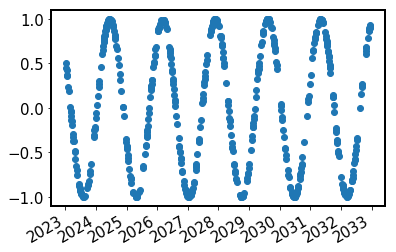

In [81]:
# Show that it worked ... 
import matplotlib.dates as mdates
mags = np.sin(mjd_lsst / 100)
fig,ax = plt.subplots()
date = Time(mjd_lsst, format='mjd')
plt.plot_date(date.datetime, mags)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()

### Simulate LSST photometric uncertainty <a id='errors'></a>
[go to top](#toc) 

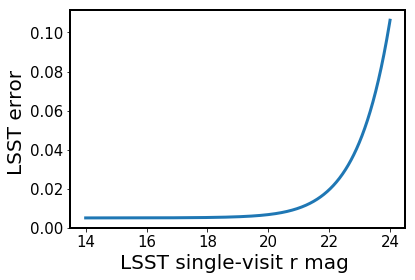

In [197]:
def calc_lsst_error(m):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    sigma_sys = 0.005
    gamma = 0.039 
    m5 = 24.7
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

# Illustrate 
# Plot the error curve 
m = np.linspace(14,24,1000)
e = calc_lsst_error(m)
plt.plot(m,e, lw=3)
plt.xlabel('LSST single-visit r mag ')
plt.ylabel('LSST error ')
plt.savefig('LSST_error_curve_rband.png', bbox_inches='tight')

### For all light curves, illustrate the survey-specific baseline extent <a id='baselines'></a>
[go to top](#toc) 

Retrieve for each light curve the start time and end time... 

In [59]:
# combined light curves : to provide SDSS,CRTS,PS1,PTF time stamps and errors 
saveDir = '../data_products/Combined_LC/'
lcs=  os.listdir(saveDir)
stats = {'lcname':[]}

for survey  in ['sdss','crts', 'ps1', 'ptf', 'lsst'] : 
    for i in '12':
        stats['t'+i+survey] = []
for i in range(len(lcs)):
    if (i % 1000) == 0 : 
        print(i)
    lcname = lcs[i]
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    for survey in np.asarray(np.unique(lc_comb['originSurvey'])): 
        m = np.in1d(lc_comb['originSurvey'] , survey)
        stats['t1'+ survey ].append(min(lc_comb['mjd'][m]))
        stats['t2'+ survey ].append(max(lc_comb['mjd'][m]))
    stats['lcname'].append(lcname)
    
# Add LSST simulated cadences ... 
# since I just used one set of epochs for all LCs,  
# I only need to check once what was the beginning and end ...
mjd_lsst = np.loadtxt('mjd_lsst_ten_years_500_epochs.txt')
stats['t1lsst'] = np.ones_like(stats['t1sdss']) * min(mjd_lsst)
stats['t2lsst'] = np.ones_like(stats['t1sdss']) * max(mjd_lsst)

0
1000
2000
3000
4000
5000
6000


Make the plot of baselines... 

sdss 0 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
ps1 1 (1.0, 0.4980392156862745, 0.054901960784313725)
ptf 2 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
crts 3 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
lsst 4 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


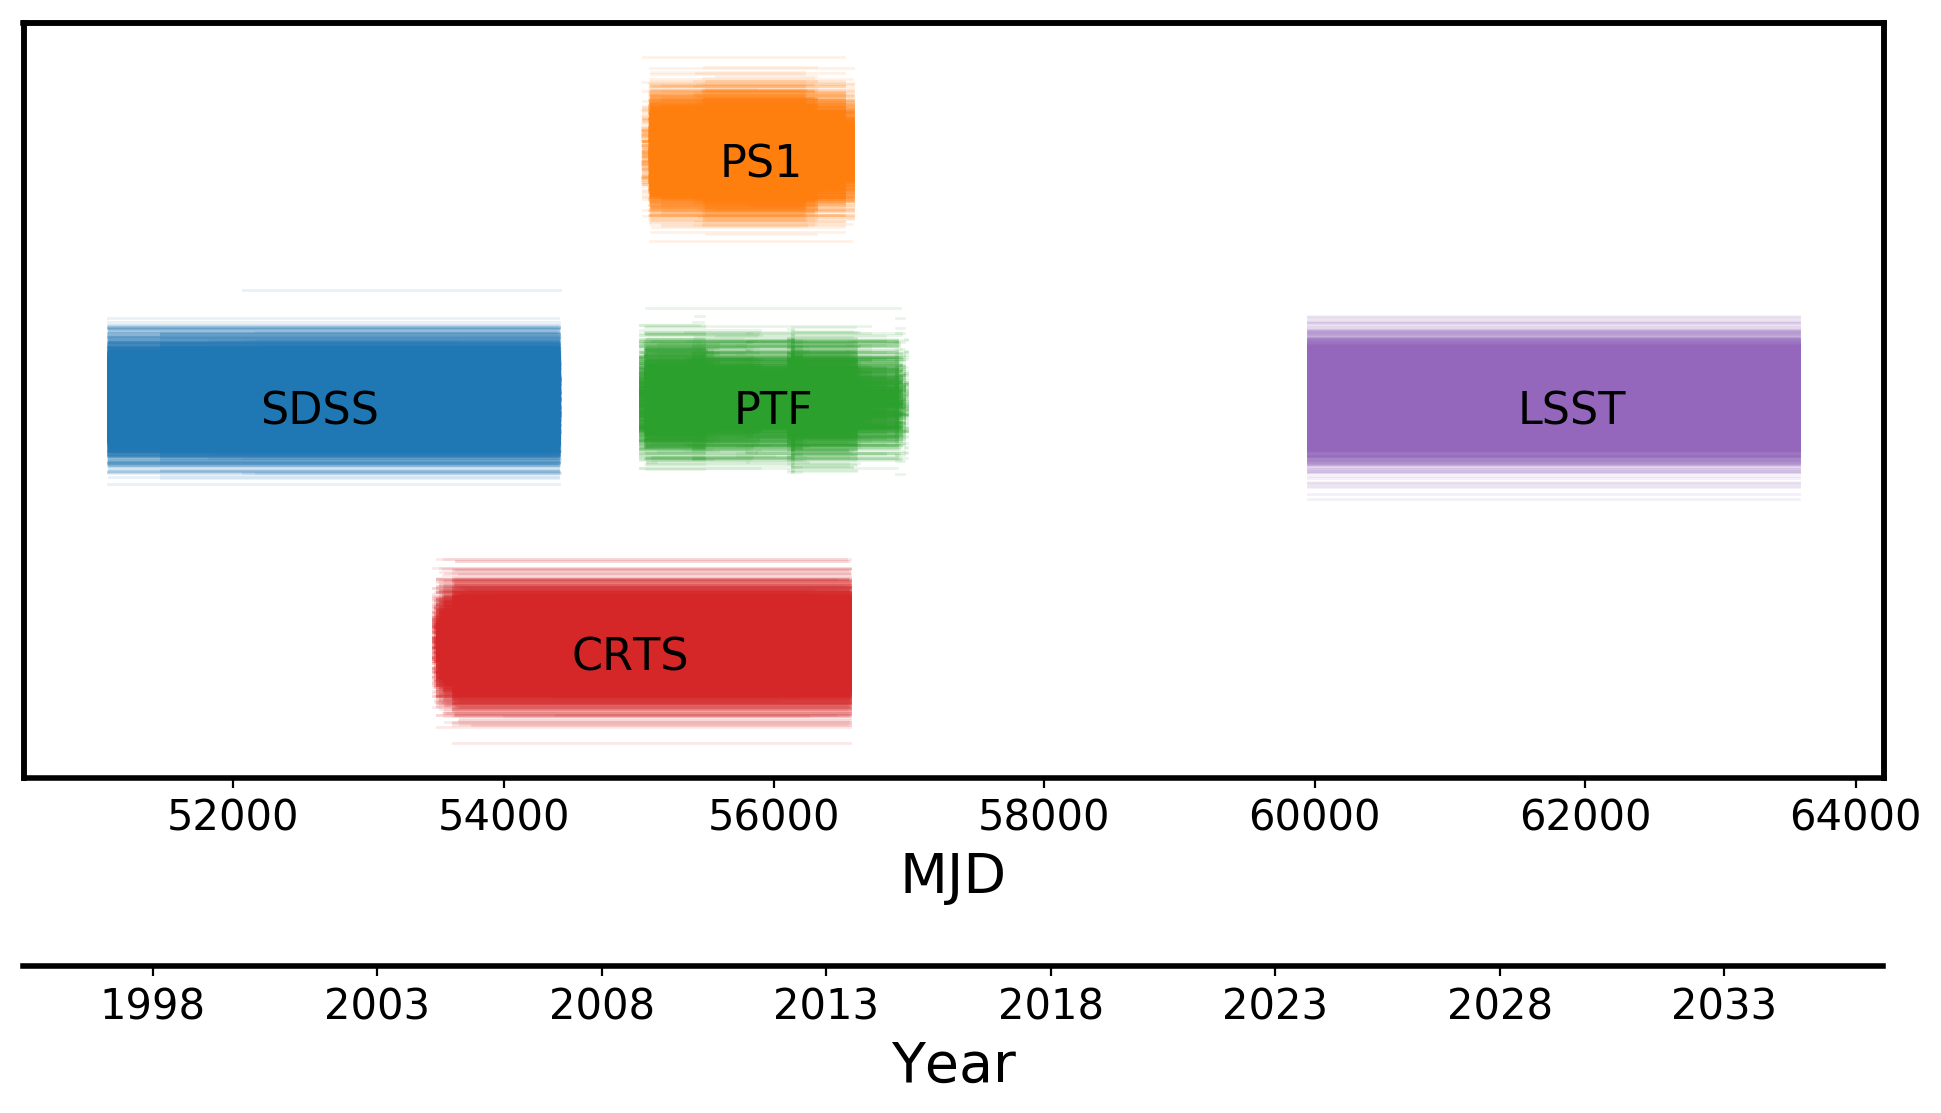

In [177]:
# assign colors to surveys using seaborn palette
import seaborn as sns 
from astropy.time import Time
import matplotlib.dates as mdates
%config InlineBackend.figure_format='retina'
current_palette = sns.color_palette()
sns.palplot(current_palette)

seg = 'sdss-ps1-ptf-crts-lsst'
cdic = {}
for i, survey in enumerate(seg.split("-")):
    color = current_palette[i] 
    print(survey,i,color)
    cdic[survey]= color 
    
# vertical offset : where the lines should be ... 
ydic = {'sdss' : 1.0 , 'crts': 0.9,  'ps1':1.1,  'ptf':1.0,  'lsst':1.0}

# position of laberl 
xdic = {'sdss': 52200,  'crts':  54500, 'ps1': 55600,  'ptf': 55700,
       'lsst': 61500}


# Make the plot showing the coverage ...
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(12,5), dpi=100)

plot_surveys = ['sdss','crts', 'ps1', 'ptf', 'lsst']
for i in range(len(stats['lcname'])-1):
    for survey in  plot_surveys : 
        xs = [stats['t1'+survey][i], stats['t2'+survey][i]]
        # add small Gaussian offset to each horizontal line ... 
        offset = np.random.normal(loc=0, scale=0.01,) 
        y = ydic[survey] + offset 
        ys = [y,y]
        ax.plot(xs,ys,  lw=1, c = cdic[survey], alpha=0.1 )
        
# add survey labels
for survey in plot_surveys: 
    ax.text(xdic[survey], ydic[survey]-0.01, survey.upper(),
           fontsize=16)

ax.set_xlabel('MJD')

# store xlims, ylims for the original axis 
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# make another axis with years ... 
ax2 = ax.twiny()

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.25))

# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
#for sp in ax2.spines.items():
#    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)

#ax2.set_xticks(new_tick_locations)
#ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Year")

mjd = np.linspace(xlims[0], xlims[1], 10)
t = Time(mjd, format='mjd')
ax2.plot_date(t.datetime, np.zeros(len(t)), markersize=0)
ax2.set_ylim(ylims)
ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#fig.autofmt_xdate()
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.set_yticks([])
plt.savefig('lightcurves_extent.png', bbox_inches='tight')

### Loop over light curves, simulate DRW, sample at given mjd, add obs noise, store altogether <a id='simulate'></a>
[go to top](#toc)

In [154]:
# combined light curves : to provide SDSS,CRTS,PS1,PTF time stamps and errors 
saveDir = '../data_products/Combined_LC/'
lcs=  os.listdir(saveDir)

for i in range(len(lcs)):
    if (i % 1000) == 0 : 
        print(i)
    lcname = lcs[i]
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    # sort by mjd .... 
    lc_comb.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')
    #print(len(lc_comb))

    # simulate true underlying DRW signal  
    # We simulate with tau=575 days,  SF_inf = 0.2 mag, which are the 
    #  median observed-frame values for the S82 quasar sample (MacLeod+2011, Sec.5.1)
    SF_inf = 0.2  # mags 
    sigma_in = SF_inf / np.sqrt(2)
    tau_in = 575 # days 
    
    t = np.append(np.asarray(lc_comb['mjd']), 
                  mjd_lsst) # combine the times from the LC and LSST 
    y_true = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , np.mean(lc_comb['mag']))
    
    # add info about lsst 
    survey = np.append(np.asarray(lc_comb['originSurvey']), 
                       np.repeat('lsst',len(mjd_lsst)))
    
    # add LSST error 
    error = np.append(np.asarray(lc_comb['magerr']),
                      calc_lsst_error(y_true[-len(mjd_lsst):]))

    # add info on band of origin 
    band = np.append(np.asarray(lc_comb['originBand']), 
                     np.repeat('r', len(mjd_lsst)))
    
    # add observational noise to DRW 
    y_obs = y_true + error * np.random.normal(loc=0,scale=1,size=len(y_true))
    #print(len(t), len(y_true), len(y_obs), len(error), len(band), len(survey))
    # make a new table : 
    lc_sim = Table([t, y_true, y_obs, error, band, survey], 
                  names=['mjd','magtrue', 'magobs', 'magerr',
                         'originBand', 'originSurvey'])

    outDir  = '../data_products/Simulated_LC_w_LSST/'
    # store the new table
    lc_sim.write(outDir+lcname, format='ascii', overwrite=True)

0
1000
2000
3000
4000
5000
6000


### Fit sections and all together ... <a id='fit'></a>
[go to top](#toc)

In [2]:
def fit_with_celerite(lc, lcname, dic,  prior='Jeff2', mjdcol='mjd',  
                      magcol = 'magobs',  errcol = 'magerr',
                     store_results = True, plot = False, axis=None,
                     plotlogP = False, tau_in = 575, 
                      sigma_in = 0.2 / np.sqrt(2.0)): 
    # fit the observed simulated LC and real LC 
    # with Celerite MAP and Expectation value ...
    
    # set limits for grid, MAP , and prior 
    sig_lims , tau_lims = [0.02,0.7], [1,5000]
    # find the Celerite expectation value and MAP 
    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc[mjdcol],lc[magcol],
                              lc[errcol],sigma_in, tau_in, prior=prior,
                                set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)
    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid, lc[magcol], gp, prior)

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                            tau_grid)
    if store_results : 
        # store the results 
        dic['sigmaMAP'].append(sigmaMAP)
        dic['sigmaEXP'].append(sigmaEXP)
        dic['tauMAP'].append(tauMAP)
        dic['tauEXP'].append(tauEXP)
        dic['lcname'].append(lcname)
        dic['length'].append(max(lc[mjdcol]) - min(lc[mjdcol]))
        
    if plot  :
         # plot the prediction conditioned on the observed data 
        x = np.linspace(min(lc[mjdcol]), max(lc[mjdcol]), 5000)
        pred_mean, pred_var = gp.predict(lc[magcol], x, return_var=True)
        pred_std = np.sqrt(pred_var)
        color = "lavender"# "#ff7f0e"
        axis.plot(x, pred_mean, color=color)
        axis.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                         color=color, alpha=0.3,
                         )
    if plotlogP : 
        # plot the logP
        mod.plot_logP(logP, sigma_grid,tau_grid, sigmaMAP, tauMAP,  
                     sigma_in, tau_in, scale,verbose=True)

In [ ]:
# Fit all combined LCs  with Celerite ...
date = '190222' # '181205'   # 
prior = 'Jeff1'   #  'Jeff1' 

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# simulated light curves , 
# including the true signal, as well as 
# signal with added Gaussian noise
# each realization is sampled at cadences 
# corresponding to real SDSS r,  PTFgR, PS1gri , CRTS V epochs,
# as well as added LSST epochs 
simDir = '../data_products/Simulated_LC_w_LSST/'
lightcurve_list =  os.listdir(simDir)

# define the storage dictionary .... 
results = {}
segments  = ['sdss', 'sdss-ps1', 'sdss-ps1-lsst']
             #'sdss-ps1-ptf-crts','sdss-ps1-ptf-crts-lsst', 
            

for segment in segments : 
    results[segment]  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[], 
                          'tauMAP':[], 'tauEXP':[],
                          'length':[] }
    
for i in range(len(lightcurve_list)):
    print(i)
    lcname = lightcurve_list[i]
    
    # read in  the observed LC : already done the steps above earlier 
    lc_obs = Table.read(simDir + lcname , format='ascii')
    
    # fit the simulated observation 
    # take segments of each light curve ... 
    for segment in segments : 
        lc = lc_obs[np.in1d(lc_obs['originSurvey'], segment.split(sep='-'))]
        #print(results[sim][segment])
        fit_with_celerite(lc, lcname , results[segment] , prior)
    
    # store the fit 
    if i % 1000 == 0 : 
        # store the intermittent results : up to i-th file, 
        # for this combination of {survey, error} in a file ..
        fname = date + '_Celerite_sim_w_LSST_'+prior+'_'+str(i)+'.npy'
        print('Saved intermittent results up to i=',i, ' as ', fname)
        np.save(fname, results)
        
# store the final thing...
fname = date + '_Celerite_sim_w_LSST_'+prior+'.npy'
print('Saved final Celerite results  to ', fname)
np.save(fname, results)

   



0
Saved intermittent results up to i= 0  as  190222_Celerite_sim_w_LSST_Jeff1_0.npy
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
3

1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


### Plot the results ... <a id='plot'></a>
[go to top](#toc)

In [12]:
date = '181205'
prior='Jeff2'
fname = date + '_Celerite_sim_w_LSST_'+prior+'.npy'
r = np.load(fname).item()

In [13]:
r['sdss'].keys()

dict_keys(['lcname', 'sigmaMAP', 'sigmaEXP', 'tauMAP', 'tauEXP', 'length'])

In [17]:
# combine dictionaries into df, join all on lcname 
seg = list(r.keys())
import matplotlib.lines as mlines
# sdss
d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

# sdss-ps1
d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

t12 =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])

# sdss-ps1-lsst
d3 = pd.DataFrame.from_dict(r[seg[2]])
t3 = Table.from_pandas(d3)  # add _sdss-ps1-lsst suffix 
for c in t3.colnames[1:] : t3.rename_column(c, c+'_'+seg[2])
    
# join all tables 
tall  = join(t12,t3,keys='lcname')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


Saved as  Simulated_DRW_w_LSST_Jeff2EXP.png


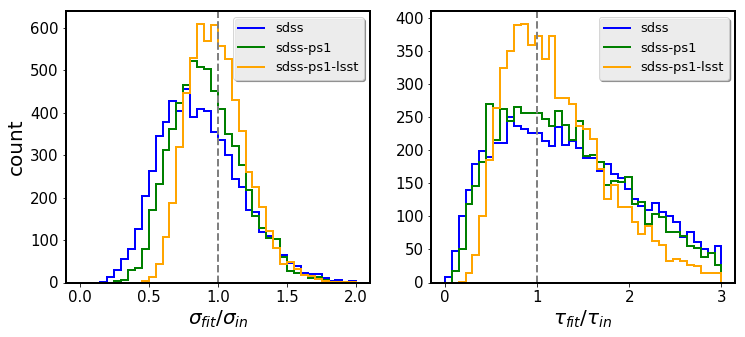

In [19]:

# plot 

# select which results to plot 
fit = 'EXP'# 'MAP'#'EXP'

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []
lw = 2 

i = 0 
for s in seg : 
    ax[0].hist(tall['sigma'+fit+'_'+s] / sigma_in , histtype='step', 
               bins=40, range=[0,2], color = colors[i],lw=lw) 
    ax[0].set_xlabel(r'$\sigma_{fit} / \sigma_{in}$')
    line = mlines.Line2D([], [],  color=colors[i], label=s,lw=lw)
    ax_legend_handles.append(line)
    i += 1 


i = 0 
for s in seg : 
    ax[1].hist(tall['tau'+fit+'_'+s] / float(tau_in) , histtype='step', 
               bins=40, range=[0,3], color = colors[i],lw=lw) 
    ax[1].set_xlabel(r'$\tau_{fit} / \tau_{in}$')
    i += 1 

for j in range(2):
    ax[j].legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.0, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=13 ) 
             
ax[0].axvline(1, lw=2, ls='--', c='grey')
ax[1].axvline(1, lw=2, ls='--', c='grey')

ax[0].set_ylabel('count')

#fig.suptitle( 'Simulated DRW , '+ fit , fontsize = 15)
figname = 'SimDRW_w_LSST_'+prior+'-'+fit+'-'+date'.png' 
print('Using ', fname)
print('Saved as ', figname)
plt.savefig(figname, bbox_inches="tight")

In [291]:
seg = list(r.keys())
seg

['sdss', 'sdss-ps1', 'sdss-ps1-lsst']

sdss 0 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
sdss-ps1 1 (1.0, 0.4980392156862745, 0.054901960784313725)
sdss-ps1-lsst 2 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
sdss
0 mean:  -0.113391376671 median:  -0.104452116082
1 mean:  0.0222522081304 median:  0.0754990062957
2 mean:  -0.0818122180848 median:  -0.0711585664482
3 mean:  0.0631583171728 median:  0.112715781774
sdss-ps1
0 mean:  -0.0805311179149 median:  -0.0761261086459
1 mean:  0.0337760412019 median:  0.0734436181894
2 mean:  -0.0509144778511 median:  -0.0448919566021
3 mean:  0.0592332801275 median:  0.0929964989456
sdss-ps1-lsst
0 mean:  -0.0348296782734 median:  -0.0352132227391
1 mean:  0.0429328630026 median:  0.0498159444295
2 mean:  -0.0106905974177 median:  -0.00986191788304
3 mean:  0.0482781617114

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


 median:  0.0532880535727


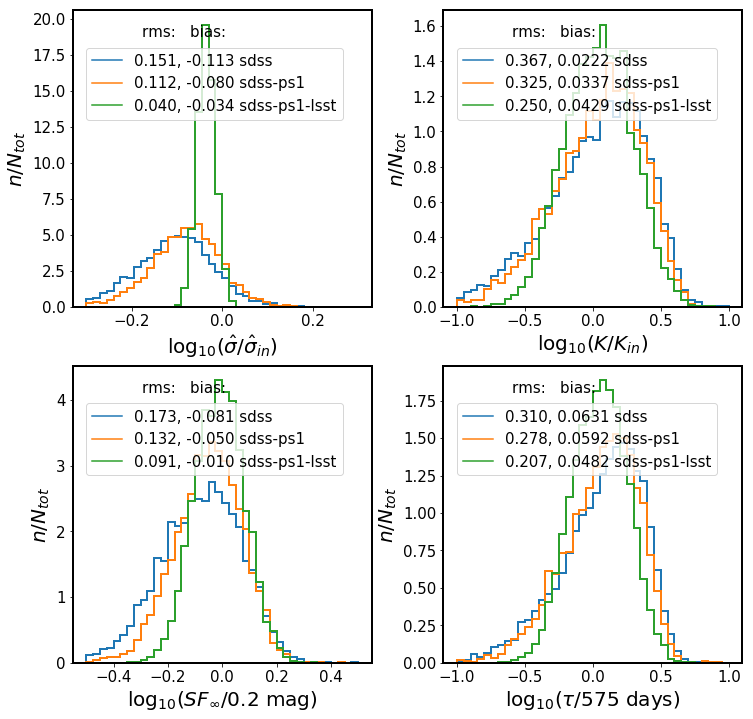

In [33]:
%matplotlib inline
# validate that the results including LSST  are consistent with Fig.18 from MacLeod+2011: 
import seaborn as sns 
import matplotlib.lines as mlines
current_palette = sns.color_palette()

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 
sigma_hat_in = sigma_in * np.sqrt(2) / np.sqrt(tau_in) #  mag / sqrt(days) 
K_in = tau_in * np.sqrt(SF_inf)

# define plotting space 
fig,axs = plt.subplots(2,2, figsize=(12,12))
ax  = np.ravel(axs)
def rms(x):
    return np.sqrt(np.mean(np.square(x)))
    
# define color dic .... 
cdic = {}
for i in range(len(seg)):
    color = current_palette[i] 
    print(seg[i],i,color)
    cdic[seg[i]] = color 
    

x_label = {0:r'$\log_{10}{(\hat{\sigma}/\hat{\sigma}_{in})}$',
           1:r'$\log_{10}{(K / K_{in})}$',
           2:r'$\log_{10}{(SF_{\infty} / 0.2 }$'+' mag)',
           3:r'$\log_{10}{(\tau / }$'+'575 days)'}
x_range = {0:[-0.3,0.3],
          1:[-1,1],
          2:[-0.5,0.5],
          3:[-1,1]}

ax_legend_handles = {0:[], 1:[], 2:[], 3:[]}

fit = 'EXP'
for s in seg : 
#s = 'sdss-ps1-lsst'
    # two independent fitted quantities
    tau = np.asarray(tall['tau'+fit+'_'+s])
    sigma = np.asarray(tall['sigma'+fit+'_'+s])

    m = tau > 3  # remove spurious fits 

    # other derived, dependent quantities 
    SF_inf_fit = sigma * np.sqrt(2)
    sigma_hat = SF_inf_fit / np.sqrt(tau)
    K = tau * np.sqrt(SF_inf_fit)


    x_plot = {0:np.log10(sigma_hat[m] / sigma_hat_in ),
              1:np.log10(K[m]/K_in),
              2:np.log10(SF_inf_fit[m] / SF_inf),
              3:np.log10(tau[m] / tau_in)
             }

    print(s)
    for i in range(len(ax)):
        x = x_plot[i]
        ax[i].hist(x, histtype='step',
                  bins=40, range=x_range[i],normed=True, lw=2,
                  color = cdic[s])
        #ax[i].text(0.6, 0.8, 'rms = '+str(rms(x))[:6], transform = ax[i].transAxes,
        #          fontsize=16, )
        ax[i].set_xlabel(x_label[i])
        ax[i].set_ylabel(r'$n/N_{tot}$')
        bias = np.mean(x)
        print(i, 'mean: ', bias, 'median: ', np.median(x))
        line = mlines.Line2D([], [], color=cdic[s],label=str(rms(x))[:5]+\
                             ', '+str(bias)[:6]+' '+s )
        ax_legend_handles[i].append(line)
    
# add legends, axis props 
for i in range(len(ax)):
    ax[i].text(0.23, 0.91, 'rms:   bias:',transform=ax[i].transAxes, fontsize=15)
    leg = ax[i].legend(loc='upper left', handles = ax_legend_handles[i],
                bbox_to_anchor=(0.02, 0.9), fontsize=15,fancybox=True)
    
fig.subplots_adjust(wspace=0.24)
#fig.suptitle(s, fontsize=16)
print('Using ', fname)
print('Saved the plot as ', figname)
figname = 'macleod2011_Fig18_'+prior+'-'+date+'.png'
plt.savefig(figname,
            bbox_inches='tight')

Check the light curve length ... 


### Illustrate fitting simulated light curves with LSST data <a id='illustrate'></a>
[go to top](#toc)

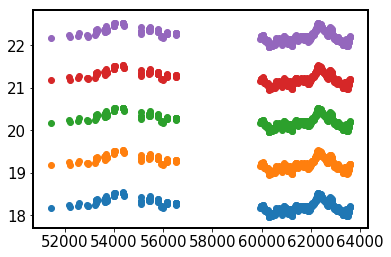

In [216]:
for i in range(5):
    plt.scatter(lc['mjd'], lc['magobs'] + i , c = current_palette[i])

sdss 0 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
ps1 1 (1.0, 0.4980392156862745, 0.054901960784313725)
ptf 2 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
crts 3 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
lsst 4 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


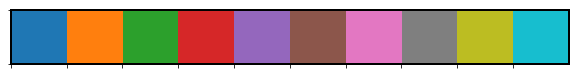

In [4]:
# assign colors to surveys using seaborn palette
import seaborn as sns 
current_palette = sns.color_palette()
sns.palplot(current_palette)

seg = 'sdss-ps1-ptf-crts-lsst'
cdic = {}
for i, survey in enumerate(seg.split("-")):
    color = current_palette[i] 
    print(survey,i,color)
    cdic[survey]= color 

Saved as  ../data_products/Combined_LC_figs/3130189_w_LSST2.png


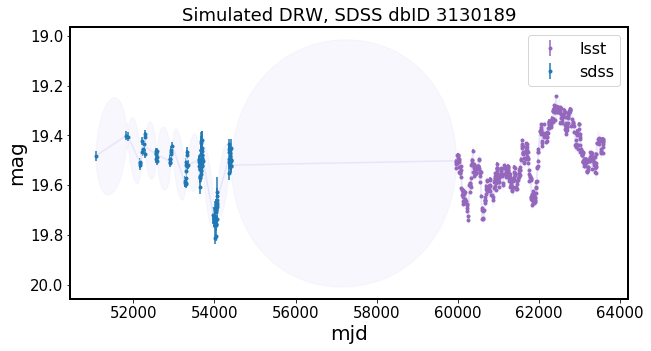

In [11]:
%matplotlib inline
import seaborn as sns 
current_palette = sns.color_palette()
# Input parameters for simulated light curves ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

simDir = '../data_products/Simulated_LC_w_LSST/'
segments  = ['sdss-ps1-ptf-crts-lsst', 'sdss-ps1-lsst', 'sdss-lsst']
j = 2
segment  = segments[j]
magcol = 'magobs'
#i = 1
#lcs=  os.listdir(simDir)
lcs = ['1987463.txt', '1088546.txt', '1072282.txt', '1475888.txt']
lcs = ['3130189.txt']
for i in range(len(lcs)):
    lcname = lcs[i]
    # read in  the observed simulated DRW LC 
    lc_obs = Table.read(simDir + lcname , format='ascii')

    # define the storage dictionary .... 
    results = {}
    
    # fit the simulated observation 
    # choose desired segments from the light curve 
    #for segment in segments : 
    
    lc = lc_obs[np.in1d(lc_obs['originSurvey'], segment.split(sep='-'))]

    # make a plot 
    fig,ax  = plt.subplots(1,1,figsize=(10,5))

    # plot the simulated data coloring 
    # by epochs corresponding to each survey ... 
    #cs = ['magenta', 'red', 'green', 'blue', 'purple']
    for survey  in np.unique(lc['originSurvey']):
        m = lc['originSurvey'] == survey
        ax.errorbar(lc['mjd'][m], lc[magcol][m], lc['magerr'][m], 
                label=survey, fmt=".", capsize=0, c=cdic[survey])

    # fit with celerite the entire segment, overplotting the fit 
    fit_with_celerite(lc, lcname , {} , 'Jeff2', store_results=False,
                     plot = True, axis=ax)

    # add labels and legends 
    ax.set_title('Simulated DRW, SDSS dbID '+ lcname[:-4])
    #ax[0].text(0.1,0.8, 'combined LC', transform = ax[0].transAxes,fontsize=16)
    ax.legend(fontsize=16)
    ax.set_xlabel('mjd')
    ax.set_ylabel('mag')
    ax.invert_yaxis()

    fname = '../data_products/Combined_LC_figs/'+lcname[:-4]+'_w_LSST'+str(j)+'.png'
    plt.savefig(fname, bbox_inches='tight')
    print('Saved as ', fname )

### Illustrate log Posterior space ... 

In [3]:
import imp
imp.reload(mod)

<module 'modules' from '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py'>

NameError: name 'cdic' is not defined

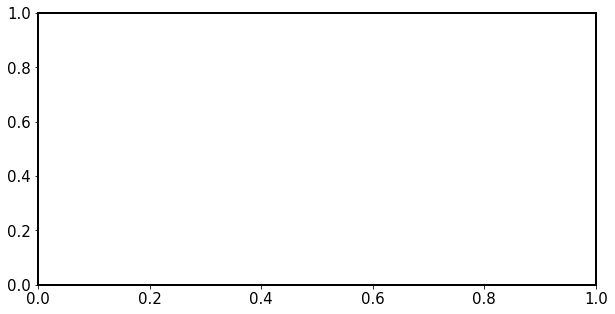

In [3]:
%matplotlib inline
simDir = '../data_products/Simulated_LC_w_LSST/'
segment = 'sdss-ps1-lsst'
magcol = 'magobs'
lcs = ['1987463.txt', '1088546.txt', '1072282.txt', '1475888.txt']
lcs = ['3130189.txt']
# few lcs picked because of excellent coverage 
for i in range(len(lcs)):
    lcname = lcs[i]
    # read in  the observed simulated DRW LC 
    lc_obs = Table.read(simDir + lcname , format='ascii')

    # fit the simulated observation 
    # choose desired segments from the light curve 
    #for segment in segments : 
    
    lc = lc_obs[np.in1d(lc_obs['originSurvey'], segment.split(sep='-'))]

    # make a plot 
    fig,ax  = plt.subplots(1,1,figsize=(10,5))

    # plot the simulated data coloring 
    # by epochs corresponding to each survey ... 
    #cs = ['magenta', 'red', 'green', 'blue', 'purple']
    for survey  in np.unique(lc['originSurvey']):
        m = lc['originSurvey'] == survey
        ax.errorbar(lc['mjd'][m], lc[magcol][m], lc['magerr'][m], 
                label=survey, fmt=".", capsize=0, c=cdic[survey])

    # fit with celerite the entire segment, overplotting the fit 
    fit_with_celerite(lc, lcname , {} , 'Jeff2', store_results=False,
                     plot = True, axis=ax, plotlogP = True)

    # add labels and legends 
    ax.set_title('Simulated DRW, SDSS dbID '+ lcname[:-4])
    #ax[0].text(0.1,0.8, 'combined LC', transform = ax[0].transAxes,fontsize=16)
    ax.legend(fontsize=16)
    ax.set_xlabel('mjd')
    ax.set_ylabel('mag')
    ax.invert_yaxis()

    #fname = '../data_products/Combined_LC_figs/'+lcname[:-4]+'_w_LSST'+str(j)+'.png'
    #plt.savefig(fname, bbox_inches='tight')


### Solve it once for all : simulate a very long, well-sampled LC, like Kozlowski did ....